<h1 align="center" id="heading">Facebook Time Series Analysis</h1>

Notebook contains the analysis of the Messenger group chat with multiple participants for the time window from `2016-08-04 11:03:40` to `2022-02-15 14:38:42`, which in total is a time span of 2021 days. All personal data has been stripped out, anonymized and replaced by names from **The Family Guy** without affecting the data itself (especially time series). The below analysis consists of the following:
- **Data Import** (combine json files and load them to Python)
- **Descriptive Statistics** (exploratory data analysis, along with text mining)
- **Time Series Analysis** (deep dive into time series techniques)
- **Time Series Predictions** (Apply different methods for Time Series Predictions: Simple, Double and Triple Exponential Smoothing methods, ARIMA: Seasonal ARIMA (SARIMA) & Seasonal Exogenous ARIMA (SARIMAX) and Facebook Prophet Model.
- **Conclude the Predictions** (Compare the evaluation of Time Series Models)
- **Forecast the Future** (Retrain all the models on the whole dataset and will forecast the future from `Feb, 2022` until `Feb 2023`, so the results can be validated in a couple of months).

## *I. Data Import*

Once you request the data from Facebook it can be delivered in multiple `.json` files depending on the size of the conversation. Below we read them one by one and save them into a single `.csv` file.

In [1]:
## Imports read messages
import os
import json
import datetime
from tqdm import tqdm
import csv
from datetime import datetime 

## Read the data from JSON & save to csv for further analysis
directory = "messages/inbox"
folders = os.listdir(directory)

for folder in tqdm(folders):
    print(folder)
    for filename in os.listdir(os.path.join(directory,folder)):
        if filename.startswith("message"):
            data = json.load(open(os.path.join(directory,folder,filename), "r"))
            for message in data["messages"]:
                try:
                    date = datetime.fromtimestamp(message["timestamp_ms"] / 1000).strftime("%Y-%m-%d %H:%M:%S")
                    sender = message["sender_name"]
                    content = message["content"]
                    with open("output.csv", 'a', encoding='latin1') as csv_file:
                        writer = csv.writer(csv_file)
                        writer.writerow([date,sender,content])

                except KeyError:
                    pass
                
## Clean Environment
from IPython import get_ipython
get_ipython().magic('clear')
get_ipython().magic('reset -f')

In [2]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

Read the `.csv` for analysis.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read data
df = pd.read_csv('output_anonym.csv', names = ['Date', 'Name', 'Text'])

# Convert as datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)

print(df.head().to_markdown())

| Date                | Name          | Text           |
|:--------------------|:--------------|:---------------|
| 2022-02-15 14:38:42 | Brian Griffin | blah blah blah |
| 2022-02-14 23:53:50 | Peter Griffin | blah blah blah |
| 2022-02-14 23:51:39 | Peter Griffin | blah blah blah |
| 2022-02-14 23:12:25 | Adam West     | blah blah blah |
| 2022-02-14 22:51:19 | Lois Griffin  | blah blah blah |


Data contains:
- `Date`: timestamp - the date and time when a message was sent
- `Name`: info who sent a message (anonymized)
- `Text`: a string of the message (anonymized)

For further analysis data is resampled on the Name variable counted for different time periods: Days, Weeks, Months, Years, indicating the number of messages sent per resampled period, e.g. if resampled daily, then each row would store a number of messages sent per a particular person for every day.

## *II. Descriptive Statistics*

Analyzed data is captured for the following time period:

In [4]:
print('From: ', df.index.min())
print('To: ', df.index.max())
print('In total, captured: ', df.index.max() - df.index.min())

From:  2016-08-04 11:03:40
To:  2022-02-15 14:38:42
In total, captured:  2021 days 03:35:02


In [5]:
#df.groupby(['Name']).describe()

![df.groupby(['Name']).describe()](df_describe.png)

- The **Count** is the number of messages sent. 
- The **Unique** indicates the number of unique messages sent. 
- The **Top** is the most common value/ message. 
- The **Freq** is the most common value’s frequency

### Plotting

For the purpose of plotting data is resampled daily

In [6]:
df_day = df['Name'].resample(rule='D').count().to_frame('Count')

print(df_day.head().to_markdown())

| Date                |   Count |
|:--------------------|--------:|
| 2016-08-04 00:00:00 |      36 |
| 2016-08-05 00:00:00 |     146 |
| 2016-08-06 00:00:00 |       0 |
| 2016-08-07 00:00:00 |       0 |
| 2016-08-08 00:00:00 |       0 |


##### Overall Messages Sent

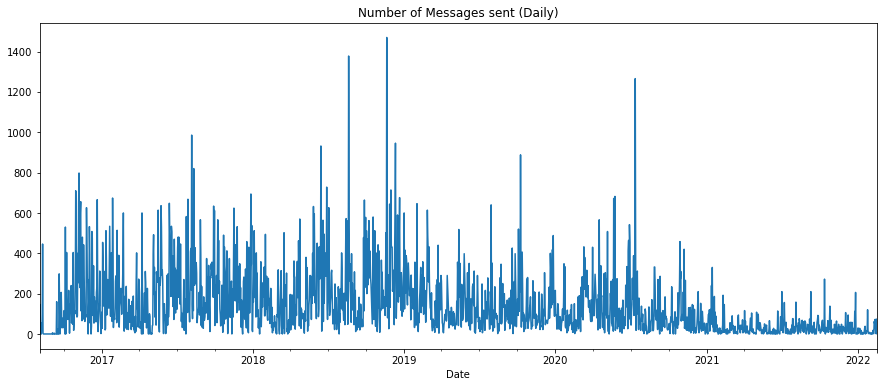

In [7]:
df_day['Count'].plot(figsize=(15,6), title = 'Number of Messages sent (Daily)');

#####  Messages Per Weekday

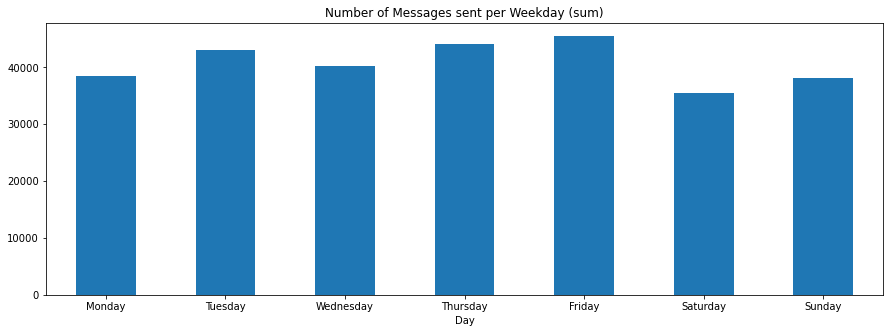

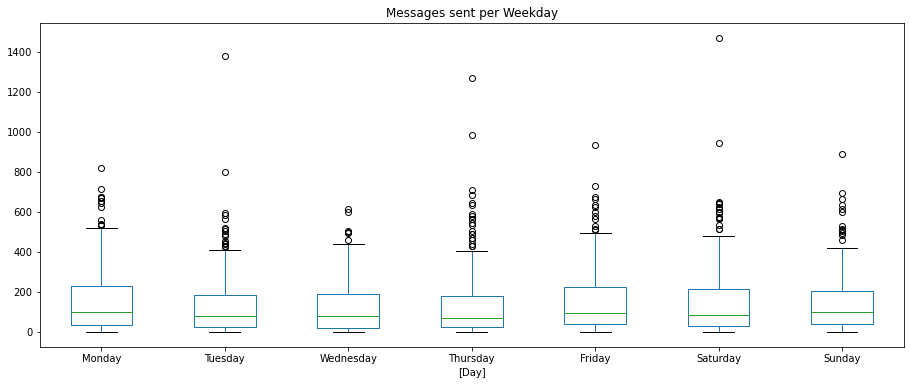

In [8]:
# Barplot
df_day['Day'] = df_day.index.day_name()
df_day.groupby('Day')['Count'].sum().reindex(["Monday", "Tuesday", "Wednesday", 
    "Thursday", 'Friday', 'Saturday', 'Sunday']).plot.bar(
    rot=0, figsize=(15,5), 
    title='Number of Messages sent per Weekday (sum)');

# Boxplot
ax = df_day.boxplot(by='Day', grid=False, figsize=(15,6));
ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", 
                    "Thursday", 'Friday', 'Saturday', 'Sunday']);
ax.set_title("Messages sent per Weekday")
# to remove default title
plt.suptitle('');

On the barplot can see that Friday has the highest sum of messages sent, while boxplots' green lines show the median for each day with dots showing outliers (there was a Saturday with more than 1400 messages sent.

##### Hour Activity

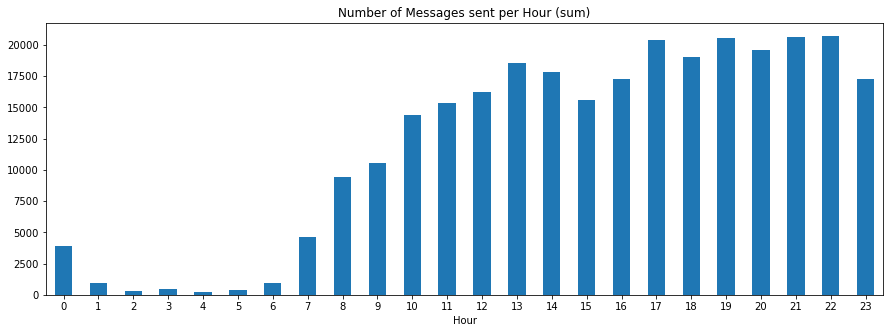

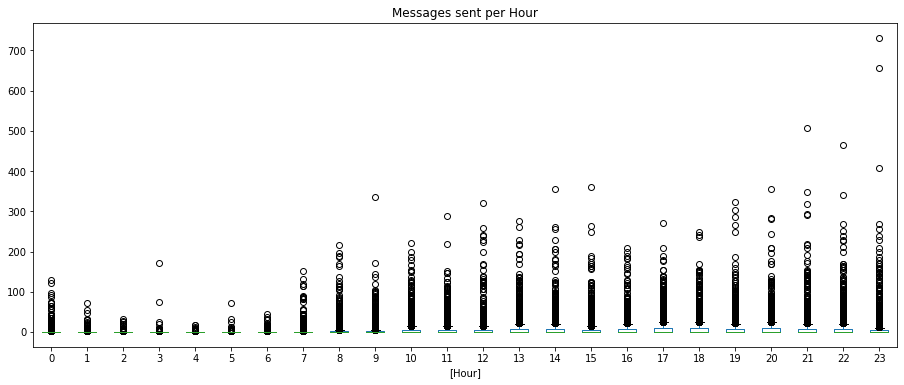

In [9]:
# Resample by Hour
df_hour = df['Name'].resample(rule='H').count().to_frame('Count')
df_hour['Hour'] = df_hour.index.hour

# Barplot
df_hour.groupby('Hour')['Count'].sum().plot.bar(
    rot=0, figsize=(15,5), 
    title='Number of Messages sent per Hour (sum)');

# Boxplot
ax = df_hour.boxplot(by='Hour', grid=False, figsize=(15,6));
# or: df_hour[['Count','Hour']].boxplot(by='Hour', grid=False, figsize=(15,5));
ax.set_title("Messages sent per Hour")
# to remove default title
plt.suptitle('');

##### Separate the data

Since data consist of multiple participants, it can be split into multiple time series and analyzed separately. The analysis is done on data resampled monthly.

In [10]:
# Resample by month
df_sep = df[['Name']].groupby('Name').resample('M').count()
df_sep = df_sep.rename(columns = {'Name':'Count'})

# Pivot
df_sep = pd.pivot_table(df_sep, values='Count', index=['Date'],
                            columns=['Name'], aggfunc=np.sum, fill_value=0)
# Show a sample 
print(df_sep.iloc[:,[0,2,6,9,10]].head().to_markdown())

| Date                |   Adam West |   Brian Griffin |   John Herbert |   Peter Griffin |   Stewie Griffin |
|:--------------------|------------:|----------------:|---------------:|----------------:|-----------------:|
| 2016-08-31 00:00:00 |         184 |             148 |             50 |             100 |              142 |
| 2016-09-30 00:00:00 |         210 |             388 |            228 |              28 |              242 |
| 2016-10-31 00:00:00 |         670 |            1278 |            578 |             300 |              798 |
| 2016-11-30 00:00:00 |        1428 |            2352 |           1192 |             210 |             1024 |
| 2016-12-31 00:00:00 |         880 |            1702 |            760 |             356 |              708 |


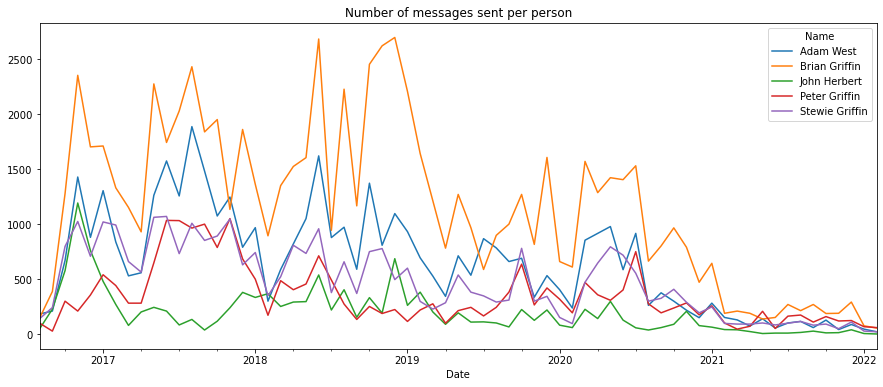

In [11]:
# Choose only a few participants to plot
df_sep.iloc[:,[0,2,6,9,10]].plot(figsize=(15,6), title = 'Number of messages sent per person');

##### Member's activity -  number of messages sent per person

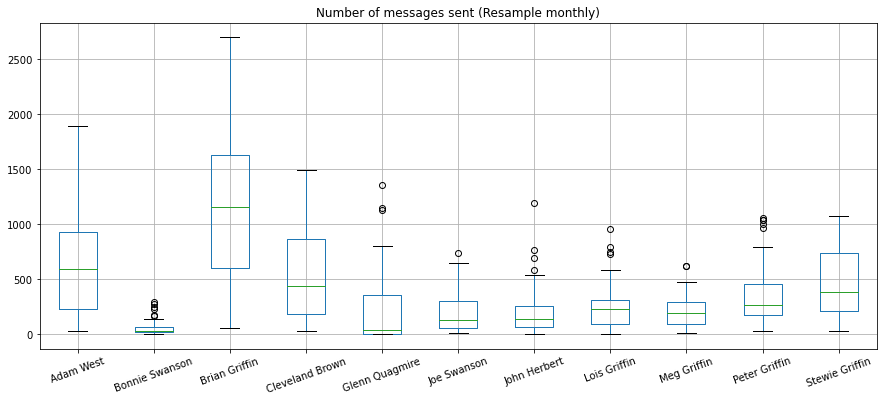

In [12]:
ax = df_sep.boxplot(figsize=(15,6), rot=20);
ax.set_title("Number of messages sent (Resample monthly)")
# to remove default title
plt.suptitle('');

##### Daily Activity

In [13]:
df_radar_plot = df.copy()
# Extract Hour from timestamp
df_radar_plot['Hour'] = df_radar_plot.index.hour
# Groupby and count
df_radar_plot = df_radar_plot.groupby(['Name','Hour'])['Hour'].count().reset_index(
    name='count')
# Pivot
df_radar_plot = pd.pivot_table(df_radar_plot, values='count', index=['Hour'],
                           columns=['Name'], fill_value=0)
# Do Percentage
df_radar_plot = (df_radar_plot.div(df_radar_plot.sum(axis=0)))*100
# Choose only a few people to visualize
df_radar_plot_filtered = df_radar_plot.iloc[ : ,[0, 2, 4, 6, 9, 10]]
# Show data
#df_radar_plot_filtered.head()
print(df_radar_plot_filtered.head().to_markdown())

|   Hour |   Adam West |   Brian Griffin |   Glenn Quagmire |   John Herbert |   Peter Griffin |   Stewie Griffin |
|-------:|------------:|----------------:|-----------------:|---------------:|----------------:|-----------------:|
|      0 |   1.50853   |       1.22412   |         1.15415  |      0.755972  |        2.78212  |        0.613305  |
|      1 |   0.285149  |       0.266563  |         0.331653 |      0.0907167 |        0.982438 |        0.156455  |
|      2 |   0.124178  |       0.0698758 |         0.132661 |      0.0302389 |        0.460789 |        0.0750986 |
|      3 |   0.193166  |       0.14234   |         0.119395 |      0.0755972 |        0.660755 |        0.0187746 |
|      4 |   0.0413926 |       0.0388199 |         0.198992 |      0         |        0.321683 |        0.0125164 |


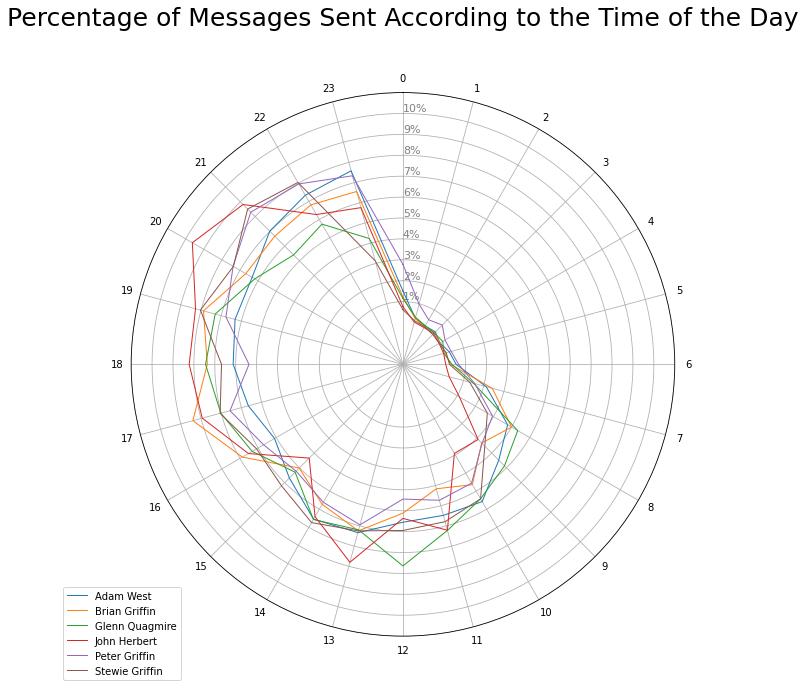

In [14]:
# Imports
from math import pi

# Create a new dataframe according to the above df
df2 = pd.DataFrame({
'group': df_radar_plot_filtered.columns.tolist(),
'0': df_radar_plot_filtered.iloc[[0]].values.flatten().tolist(),
'1': df_radar_plot_filtered.iloc[[1]].values.flatten().tolist(),
'2': df_radar_plot_filtered.iloc[[2]].values.flatten().tolist(),
'3': df_radar_plot_filtered.iloc[[3]].values.flatten().tolist(),
'4': df_radar_plot_filtered.iloc[[4]].values.flatten().tolist(),
'5': df_radar_plot_filtered.iloc[[5]].values.flatten().tolist(),
'6': df_radar_plot_filtered.iloc[[6]].values.flatten().tolist(),
'7': df_radar_plot_filtered.iloc[[7]].values.flatten().tolist(),
'8': df_radar_plot_filtered.iloc[[8]].values.flatten().tolist(),
'9': df_radar_plot_filtered.iloc[[9]].values.flatten().tolist(),
'10': df_radar_plot_filtered.iloc[[10]].values.flatten().tolist(),
'11': df_radar_plot_filtered.iloc[[11]].values.flatten().tolist(),
'12': df_radar_plot_filtered.iloc[[12]].values.flatten().tolist(),
'13': df_radar_plot_filtered.iloc[[13]].values.flatten().tolist(),
'14': df_radar_plot_filtered.iloc[[14]].values.flatten().tolist(),
'15': df_radar_plot_filtered.iloc[[15]].values.flatten().tolist(),
'16': df_radar_plot_filtered.iloc[[16]].values.flatten().tolist(),
'17': df_radar_plot_filtered.iloc[[17]].values.flatten().tolist(),
'18': df_radar_plot_filtered.iloc[[18]].values.flatten().tolist(),
'19': df_radar_plot_filtered.iloc[[19]].values.flatten().tolist(),
'20': df_radar_plot_filtered.iloc[[20]].values.flatten().tolist(),
'21': df_radar_plot_filtered.iloc[[21]].values.flatten().tolist(),
'22': df_radar_plot_filtered.iloc[[22]].values.flatten().tolist(),
'23': df_radar_plot_filtered.iloc[[23]].values.flatten().tolist()
})

# --- Background --- #
plt.figure(figsize=(14, 10)) 
    
# number of variables
categories=list(df2)[1:]
N = len(categories)
 
# Divide the plot / number of variable to determine angles of the each axis
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the radar plot
ax = plt.subplot(111, polar=True)
 
# Define the axis which will contain labels (here the first axis "Sleet")
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw varables per axis + labels
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([1,2,3,4,5,6,7,8,9,10,11], 
           ["1%","2%","3%","4%","5%","6%","7%","8%","9%","10%"], 
           color="grey", size=11)
plt.ylim(-2,11)

# --- Plots --- #
# Iterate through Pandas df2 and plot each layer
for index, row in df2.iterrows():
    values=df2.loc[index].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=row.group)
    ax.fill(angles, values, 'gray', alpha=0.)
    
# Add legend & Title
plt.legend(bbox_to_anchor=(0.1, 0.1))
plt.title('Percentage of Messages Sent According to the Time of the Day',
          fontsize=25, pad=40)
plt.show()

##### Cluster Analysis

The hierarchical clustering approach divides similar objects into groups called clusters by calculating the Euclidean distance between objects.

In [15]:
# Data format required for the algorithm
print(df_sep.T.iloc[:,[0,1,2,3]].head(3).to_markdown())

| Name           |   2016-08-31 00:00:00 |   2016-09-30 00:00:00 |   2016-10-31 00:00:00 |   2016-11-30 00:00:00 |
|:---------------|----------------------:|----------------------:|----------------------:|----------------------:|
| Adam West      |                   184 |                   210 |                   670 |                  1428 |
| Bonnie Swanson |                     0 |                     0 |                   172 |                   268 |
| Brian Griffin  |                   148 |                   388 |                  1278 |                  2352 |


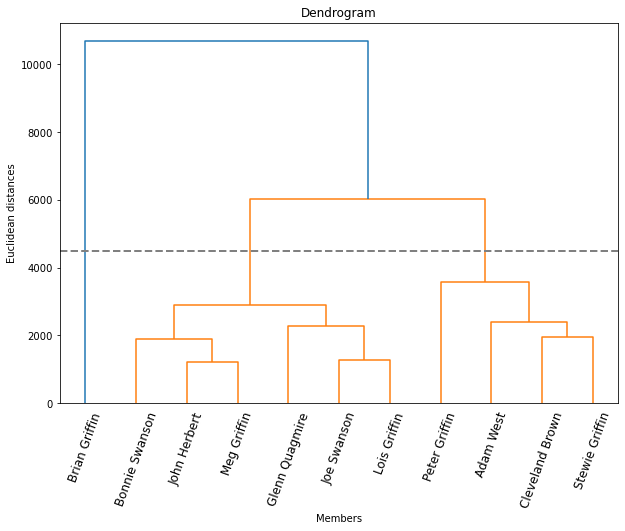

In [16]:
import scipy.cluster.hierarchy as shc

# Transpose
hc_df = df_sep.T
# Plot
plt.figure(figsize=(10, 7))
plt.title('Dendrogram')
plt.xlabel('Members')
plt.ylabel('Euclidean distances')
# Choose linkage
link = shc.linkage(hc_df, method='complete', metric='euclidean')
# Create Dendrogram
dend = shc.dendrogram(link, labels = hc_df.index.tolist(), leaf_rotation=70)
plt.axhline(y=4500, c='grey', lw=2, linestyle='dashed');

The algorithm divided group members into three main clusters (grey dashed line indicates main clusters).

### Text Mining

##### Word Cloud

There are a plethora of techniques to analyze text data. To avoid analyzing sensitive information here we will focus on WordCloud only and assume the group chat consists of Shakespeare Sonnets and the text looks as follow:

In [17]:
shakespeare_txt = pd.read_fwf('Shakespeare.txt')
#shakespeare_txt
print(shakespeare_txt.head(10).to_markdown())

|    | THE SONNETS                                           |
|---:|:------------------------------------------------------|
|  0 | From fairest creatures we desire increase,            |
|  1 | That thereby beauty's rose might never die,           |
|  2 | But as the riper should by time decease,              |
|  3 | His tender heir might bear his memory:                |
|  4 | But thou contracted to thine own bright eyes,         |
|  5 | Feed'st thy light's flame with self-substantial fuel, |
|  6 | Making a famine where abundance lies,                 |
|  7 | Thy self thy foe, to thy sweet self too cruel:        |
|  8 | Thou that art now the world's fresh ornament,         |
|  9 | And only herald to the gaudy spring,                  |


In [18]:
# Import Libraries
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

First of all, we need to remove the stopwords from the whole text.

In [19]:
# Create a dictionary of stopwords (words which we want to remove from the text)
from stopwords_en import list_words_en 
#from stopwords_pl import list_words_pl -> if analysing messenger data
list_words_en[:10]

["'ll", "'tis", "'twas", "'ve", '10', '39', 'a', "a's", 'able', 'ableabout']

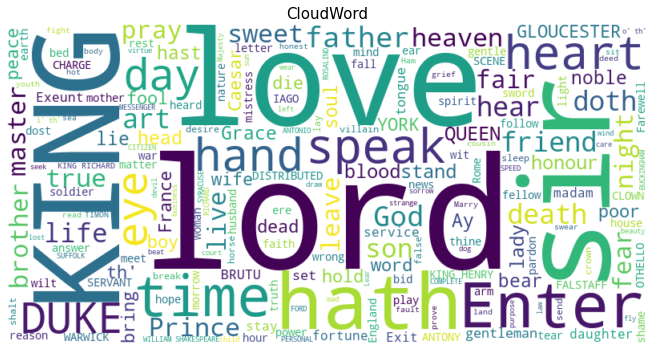

In [20]:
# Convert to plain text
text = " ".join(review for review in shakespeare_txt['THE SONNETS']) 
#text = " ".join(review for review in df['Text']) -> if analysing messenger data

# Creat stopwords
stopwords = set(STOPWORDS)
stopwords.update(list_words_en)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white",
                  width=800, height=400).generate(text)

# Plotting
fig, ax = plt.subplots(figsize=(20, 5))
ax.imshow(wordcloud,interpolation='bilinear')
ax.set_title("CloudWord",fontsize=15)
ax.axis("off")
fig.tight_layout()

The size of the word indicates how often it appears in the text.

##### The most common words used

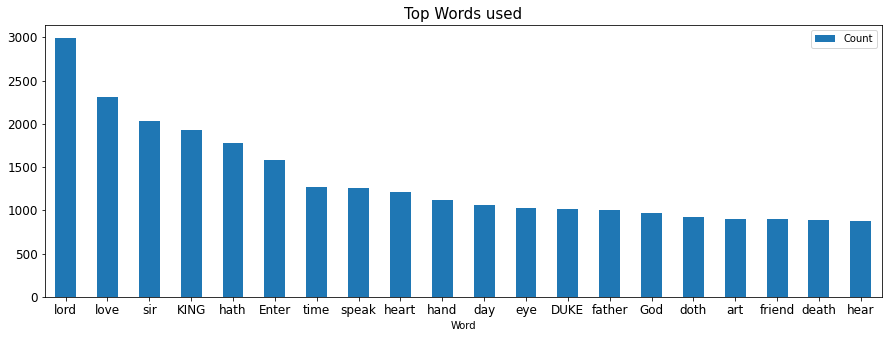

In [21]:
# Prepeare the text
word_count = WordCloud(stopwords=stopwords).process_text(text)
word_count = pd.DataFrame(word_count.items(), columns=['Key', 'Value'])
word_count.columns =['Word', 'Count']

# Sort
word_count = word_count.sort_values(by=['Count'], ascending=False)

# Choose Top
word_count_top = word_count[:20]

# Barplot      
ax = word_count_top.set_index("Word").plot.bar(figsize=(15, 5), rot=0, fontsize=12);
ax.set_title("Top Words used",fontsize=15);

## *III. Time Series Analysis*

### Visual Analysis

##### Resampling with Simple Moving Average

Investigate the data by looking at a different frequency of the time series observations with a Simple Moving Average included

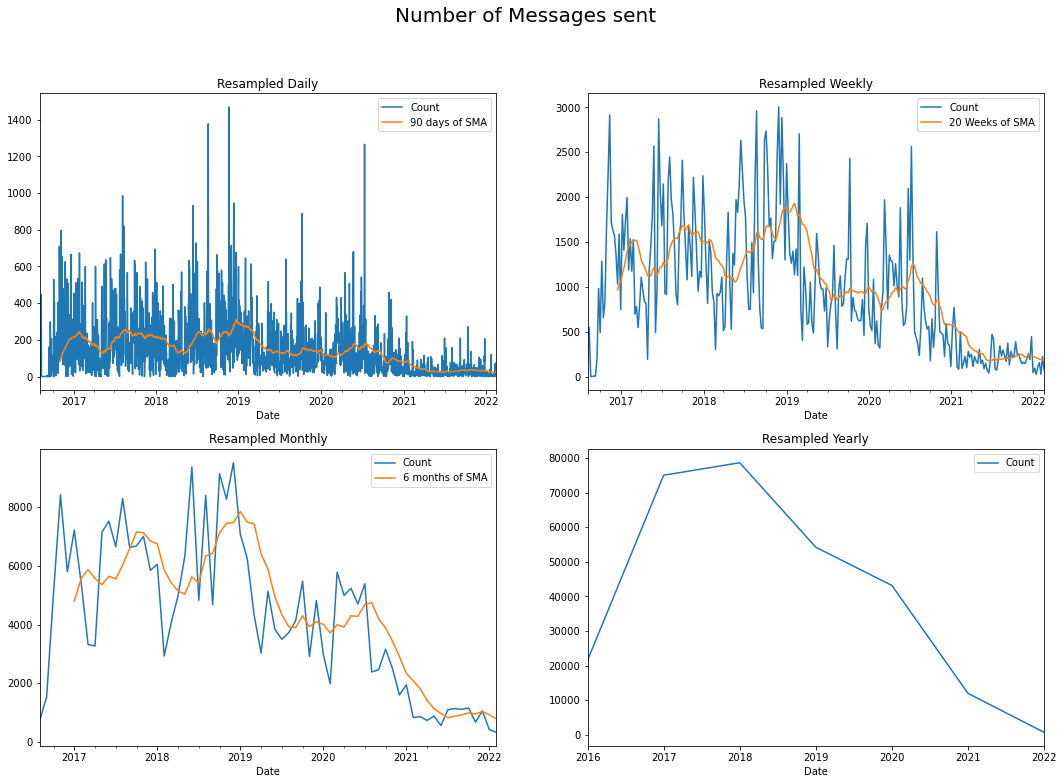

In [22]:
# Set Common space
fig,axes = plt.subplots(nrows=2, ncols=2,  figsize=(18, 12))

# Common title 
st = fig.suptitle("Number of Messages sent", fontsize= 20)

# Plots:
# Daily
df_day = df['Name'].resample(rule='D').count().to_frame('Count')
df_day['90 days of SMA'] = df_day['Count'].rolling(window = 90).mean()
df_day.plot.line(title = 'Resampled Daily', ax=axes[0,0]);

# Weekly
df_wkl = df['Name'].resample(rule='W').count().to_frame('Count')
df_wkl['20 Weeks of SMA'] = df_wkl['Count'].rolling(window = 20).mean()
df_wkl.plot.line(title = 'Resampled Weekly', ax=axes[0,1]);

# Monthly
df_month = df['Name'].resample(rule='M').count().to_frame('Count')
df_month['6 months of SMA'] = df_month['Count'].rolling(window = 6).mean()
df_month.plot.line(title = 'Resampled Monthly', ax=axes[1,0]);

# Yearly
df_year = df['Name'].resample(rule='Y').count().to_frame(
    'Count').plot.line(title = 'Resampled Yearly', ax=axes[1,1]);

The rest of the time series analysis will be based on weekly resampled data.

##### Expanding Window

Expanding Window represents a data point on the x-axis as an average of messages sent until this point in time. Thus, the last point is an average of all the dataset. On the plot can be seen the line was going up until 2021 when the curve started flattening.

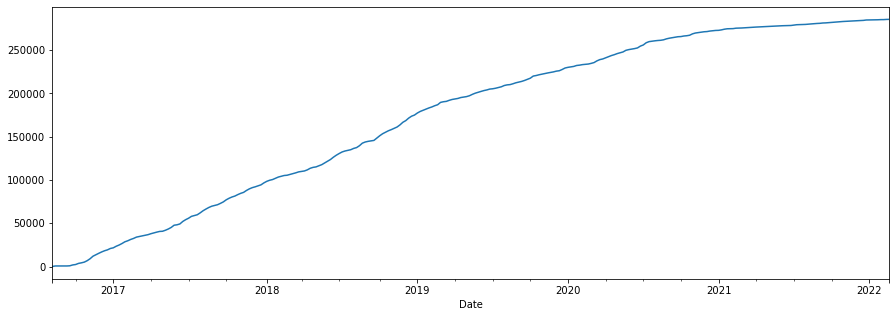

In [23]:
df_wkl['Count'].expanding().sum().plot.line(figsize=(15,5));

##### ETS Decomposition

In [24]:
# adjusting globally size of figures
from pylab import rcParams
rcParams['figure.figsize'] = 12,9

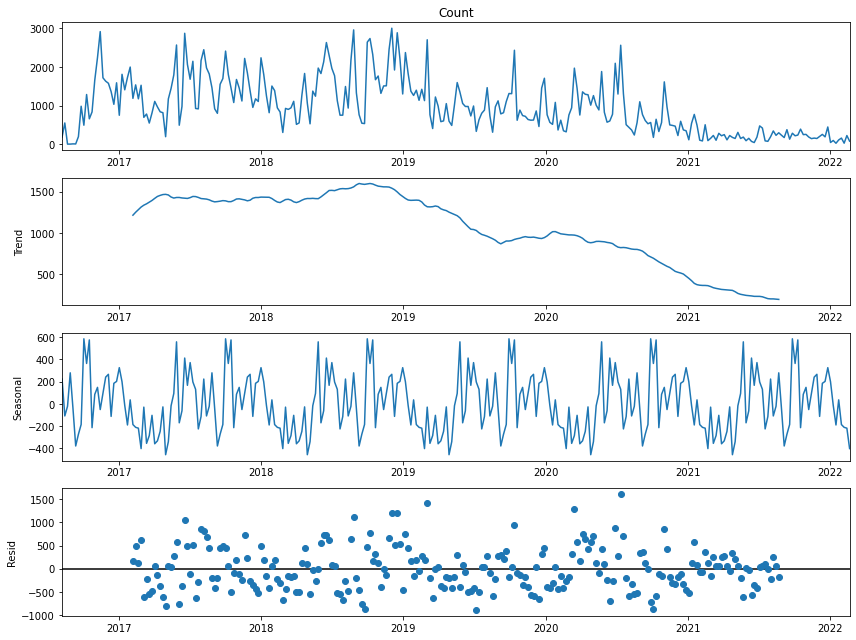

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Resample by month
df_ETS = df['Name'].resample(rule='W').count().to_frame('Count')
df_ETS.index.freq = 'W'

# ETS
result = seasonal_decompose(df_ETS['Count'])
result.plot();

A couple of observations:
- Data is non-stationary. 
- Trend is decreasing; being flat on top until the end of 2018 started to go down in 2019 and again from 2020.
- Seasonality is present. Activity is relatively low at the beginning of each year, while it has a peak at the end of each year.
- Data contains a lot of noise, which can be explained neither by the trend nor seasonality, meaning external factors contribute as well.

##### ETS Decomposition: Zoom-in to the seasonal plot for one year only

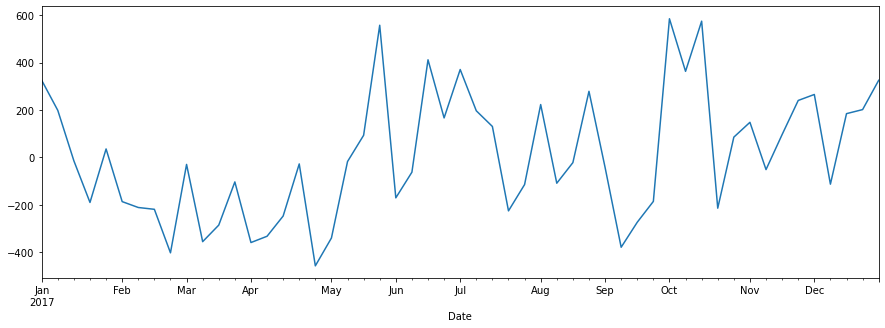

In [26]:
# Zoom-in the one year
result.seasonal.loc['2017-01-01':'2017-12-31'].plot(figsize=(15,5));

##### Lag Plot

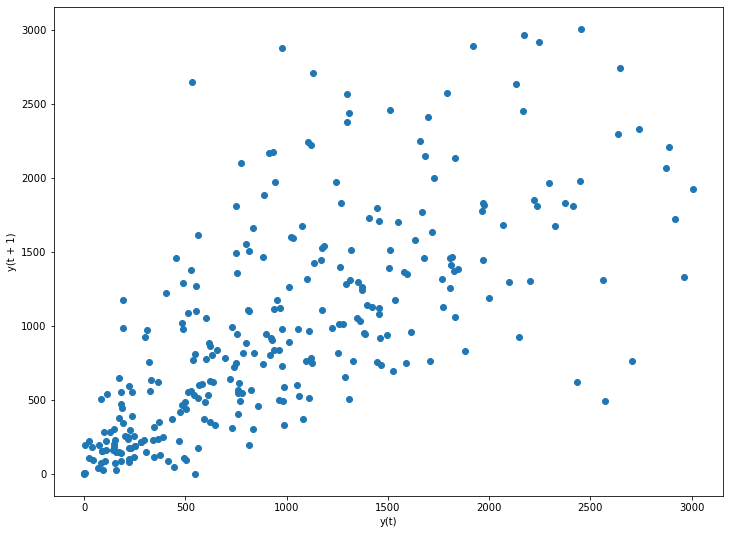

In [27]:
from pandas.plotting import lag_plot
df_test = df['Name'].resample(rule='W').count().to_frame('Count')
lag_plot = lag_plot(df_test['Count'], lag=1)
lag_plot;

Lag Plot represents a number of messages sent at time t on the X-axis vs at time t+1 on the Y-axis. A slight linear pattern suggests autocorrelation in data and that the data is not random.

##### ACF and PACF

In [28]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# plot_acf(df_test, lags =100); 
# plot_pacf(df_test, lags=100);

### Statistical Analysis 

Beyond the visual representation of time series, data can be investigated using statistical tests.

##### Test for Stationarity

Test whether the Time Series is Stationary or not.

In [29]:
from statsmodels.tsa.stattools import adfuller

# The function to test for stationarity in the data with implemented H0/H1 hypothesis
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

adf_test(df_wkl['Count'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.478960
p-value                   0.120678
# lags used               6.000000
# observations          283.000000
critical value (1%)      -3.453670
critical value (5%)      -2.871808
critical value (10%)     -2.572241
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


The statistical test confirmed what have seen on the ETS plot - the data is non-stationary.

##### Test for Causality

Since our data can be split into multiple time series, we can test the causality between them (check if lagged x-values can explain the variation in y). We will use the Granger Causality Test to determine if time series have a casual impact on each other. First, however, we have to make sure that the time series are non-stationary.

In [30]:
# Resample by week
df_sep_wkl = df[['Name']].groupby('Name').resample('W').count()
df_sep_wkl = df_sep_wkl.rename(columns = {'Name':'Count'})

# Pivot
df_sep_wkl = pd.pivot_table(df_sep_wkl, values='Count', index=['Date'],
                            columns=['Name'], aggfunc=np.sum, fill_value=0)

Choose two time series (Stewie and Peter) to test for causality and stationarity.

In [31]:
gct_df = df_sep_wkl[['Stewie Griffin', 'Peter Griffin']]
#gct_df.head()
print(gct_df.head().to_markdown())

| Date                |   Stewie Griffin |   Peter Griffin |
|:--------------------|-----------------:|----------------:|
| 2016-08-07 00:00:00 |               28 |               8 |
| 2016-08-14 00:00:00 |              114 |              92 |
| 2016-08-21 00:00:00 |                0 |               0 |
| 2016-08-28 00:00:00 |                0 |               0 |
| 2016-09-04 00:00:00 |                0 |               0 |


In [32]:
# Stewie Griffin
gct_df_one = gct_df.iloc[0:, :1]
# Peter Griffin
gct_df_two = gct_df.iloc[0:, 1:]

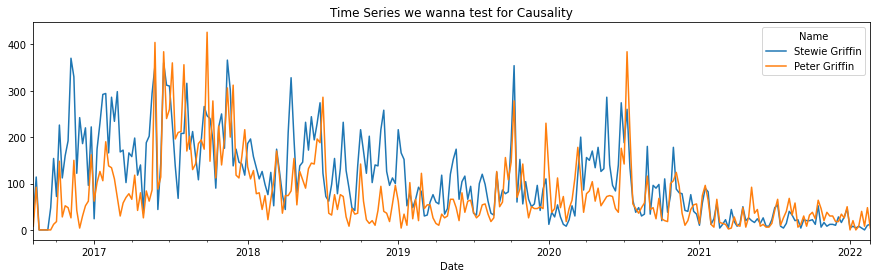

In [33]:
ax = gct_df_one.plot(figsize=(15,4), title = 'Time Series we wanna test for Causality');
gct_df_two.plot(figsize=(15,4), ax=ax);

Check Stewie's time series whether it's Stationary

In [34]:
print('First Person - Stewie Griffin')
adf_test(gct_df_one)

First Person - Stewie Griffin
Augmented Dickey-Fuller Test: 
ADF test statistic       -2.661844
p-value                   0.080877
# lags used               5.000000
# observations          284.000000
critical value (1%)      -3.453587
critical value (5%)      -2.871771
critical value (10%)     -2.572222
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


Check Peter's time series whether it's Stationary

In [35]:
print('\n Second Person - Peter Griffin')
adf_test(gct_df_two)


 Second Person - Peter Griffin
Augmented Dickey-Fuller Test: 
ADF test statistic       -3.104510
p-value                   0.026221
# lags used               5.000000
# observations          284.000000
critical value (1%)      -3.453587
critical value (5%)      -2.871771
critical value (10%)     -2.572222
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Because Stewie's Time Series is Non-Stationary, we need to find which order difference would make both time series stationary.

In [36]:
from statsmodels.tsa.statespace.tools import diff

# test k_diff=1
gct_df_diff = diff(gct_df, k_diff=1)

print('First Person - Stewie Griffin')
adf_test(gct_df_diff.iloc[0:, :1])

print('\n Second Person - Peter Griffin')
# Second person
adf_test(gct_df_diff.iloc[0:, 1:])

First Person - Stewie Griffin
Augmented Dickey-Fuller Test: 
ADF test statistic     -1.290186e+01
p-value                 4.231711e-24
# lags used             4.000000e+00
# observations          2.840000e+02
critical value (1%)    -3.453587e+00
critical value (5%)    -2.871771e+00
critical value (10%)   -2.572222e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary

 Second Person - Peter Griffin
Augmented Dickey-Fuller Test: 
ADF test statistic     -1.194527e+01
p-value                 4.445467e-22
# lags used             4.000000e+00
# observations          2.840000e+02
critical value (1%)    -3.453587e+00
critical value (5%)    -2.871771e+00
critical value (10%)   -2.572222e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


After differencing the time series by 1, both are stationary now. Once time series are prepared, we can define the statistical hypothesis.

*Null Hypothesis (H0)*: Person 2 (Peter Griffin) does not granger cause person 1 (Stewie Griffin). <br/>
*Alternative Hypothesis (H1)*: Person 2 (Peter Griffin) granger causes person 1 (Stewie Griffin).

In [37]:
# Casuality test run
from statsmodels.tsa.stattools import grangercausalitytests

# Test (Peter -> Stewie)
resu = grangercausalitytests(gct_df_diff.loc[:,['Peter Griffin', 'Stewie Griffin']], maxlag = 3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.3455 , p=0.0009  , df_denom=285, df_num=1
ssr based chi2 test:   chi2=11.4649 , p=0.0007  , df=1
likelihood ratio test: chi2=11.2426 , p=0.0008  , df=1
parameter F test:         F=11.3455 , p=0.0009  , df_denom=285, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.8552  , p=0.0005  , df_denom=282, df_num=2
ssr based chi2 test:   chi2=15.9889 , p=0.0003  , df=2
likelihood ratio test: chi2=15.5594 , p=0.0004  , df=2
parameter F test:         F=7.8552  , p=0.0005  , df_denom=282, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.2989  , p=0.0014  , df_denom=279, df_num=3
ssr based chi2 test:   chi2=16.2955 , p=0.0010  , df=3
likelihood ratio test: chi2=15.8482 , p=0.0012  , df=3
parameter F test:         F=5.2989  , p=0.0014  , df_denom=279, df_num=3


P-value is < 0.05, which indicates that we can reject H0 and conclude that: Messages sent by person 2 (Peter Griffin) granger cause replies of person 1 (Stewie Griffin).

Let's test the same but in the opposite direction: <br/>
<br/>
*Null Hypothesis (H0)* : Person 1 (Stewie Griffin) does not granger cause person 2 (Peter Griffin). <br/>
*Alternative Hypothesis (H1)* : Person 1 (Stewie Griffin) granger causes person 2 (Peter Griffin).

In [38]:
# Test (Stewie -> Peter)
resu = grangercausalitytests(gct_df_diff.loc[:,['Stewie Griffin', 'Peter Griffin']], maxlag = 3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2611  , p=0.1338  , df_denom=285, df_num=1
ssr based chi2 test:   chi2=2.2849  , p=0.1306  , df=1
likelihood ratio test: chi2=2.2759  , p=0.1314  , df=1
parameter F test:         F=2.2611  , p=0.1338  , df_denom=285, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3225  , p=0.2681  , df_denom=282, df_num=2
ssr based chi2 test:   chi2=2.6919  , p=0.2603  , df=2
likelihood ratio test: chi2=2.6793  , p=0.2619  , df=2
parameter F test:         F=1.3225  , p=0.2681  , df_denom=282, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5723  , p=0.6336  , df_denom=279, df_num=3
ssr based chi2 test:   chi2=1.7601  , p=0.6237  , df=3
likelihood ratio test: chi2=1.7547  , p=0.6248  , df=3
parameter F test:         F=0.5723  , p=0.6336  , df_denom=279, df_num=3


This time we can see the opposite and don't have enough evidence to reject H0.

# *IV. Predictions*

This section will compare several time series models and evaluate them to check which one performs the best.

We will be working on weekly resampled data and will be modeling the number of messages sent by the group per week. The whole dataset is presented below.

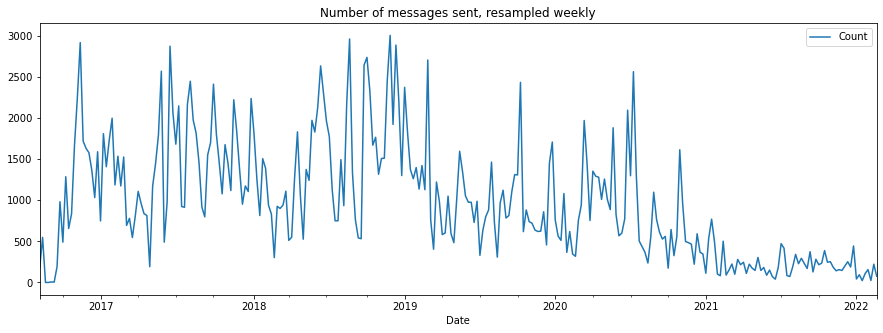

In [39]:
# Assign the data
df_pred = df['Name'].resample(rule='W').count().to_frame('Count')
# Plot
df_pred.plot(figsize=(15,5), title = 'Number of messages sent, resampled weekly');

### Data Preparation

###### Train/Test Split

We will be evaluating the model on the last 52 weeks of the data (the last ~1 year serves as a testing set and previous data as a training set).

In [40]:
# Chose number of periods to predict: 52 weeks = ~12 months
range_pred = 52

# Train/Test split
train = df_pred[:-range_pred]
test = df_pred[-range_pred:]

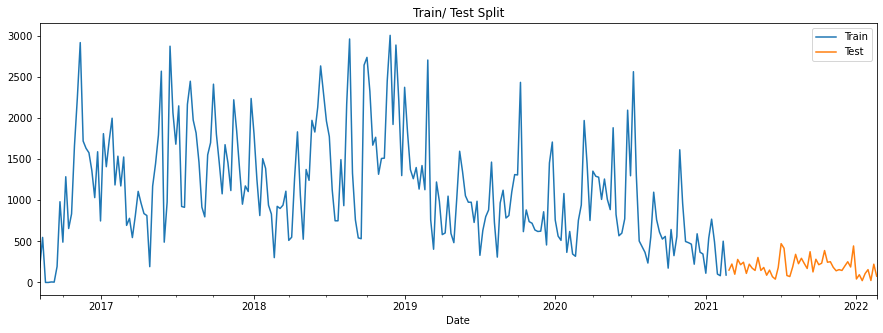

In [41]:
train['Count'].plot(legend = True, label='Train', figsize=(15,5), title = 'Train/ Test Split');
test['Count'].plot(legend = True, label='Test', figsize=(15,5));

In [42]:
print('Train Set Dates')
print(train.index.min())
print(train.index.max())

print('Test Set Dates')
print(test.index.min())
print(test.index.max())

Train Set Dates
2016-08-07 00:00:00
2021-02-21 00:00:00
Test Set Dates
2021-02-28 00:00:00
2022-02-20 00:00:00


######  Check for zero values

Weeks with zero messages will be replaced by the previous week's value.

In [43]:
# Check number of weeks with Count = 0
train[train['Count'] == 0].count()

Count    2
dtype: int64

In [44]:
# Replace 0 by the previous' row value
train['Count'] = train['Count'].replace(to_replace=0, method='ffill')
train[train['Count'] == 0].count()

Count    0
dtype: int64

### Build and Evaluate Models

Several models will be built and evaluated based on `MAE` and `RMSE` defined in the function below.

In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def eval_models(true_test, pred_test, model_name):
    
    # Calculate Metrics
    MAE = mean_absolute_error(true_test, pred_test)
    RMSE = np.sqrt(mean_squared_error(true_test, pred_test))
    
    # Save
    data = [{'Model': model_name, 
             'MAE': MAE, 
             'RMSE': RMSE }]
    
    models_results = pd.DataFrame(data)
    
    return models_results

##### 0. Baseline -  train set average

Further models created will be compared to the baseline (average of the train set). Simply assuming, without any modeling we would take the average of the past for predicting the future.

In [46]:
# Check the mean of train set
test['Train mean'] = train['Count'].mean()
train['Count'].mean()

1161.0504201680671

*Plot Results:*

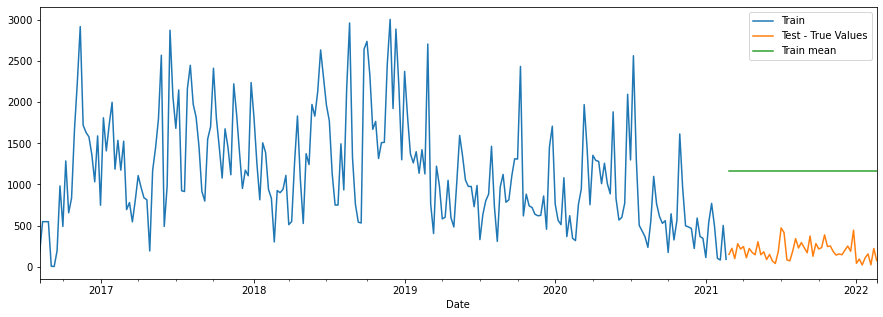

In [47]:
train['Count'].plot(legend = True, label='Train', figsize=(15,5));
test['Count'].plot(legend = True, label='Test - True Values', figsize=(15,5));
test['Train mean'].plot(legend = True, figsize=(15,5));

*Evaluate:*

In [48]:
all_results = result_0 = eval_models(test['Count'], test['Train mean'], "Baseline - train mean")
#all_results
print(all_results.to_markdown())

|    | Model                 |     MAE |    RMSE |
|---:|:----------------------|--------:|--------:|
|  0 | Baseline - train mean | 966.743 | 972.358 |


##### 1. Simple Exponential Smoothing - Single, Double and Triple

Building four models:
- SES with weights parameter (alpha). Larger alpha (i.e., close to 1) means more weight is given to the more recent observations.
- DES, where additionally trend/seasonal component is added.
- TES, where both trend and seasonal components are  included in the model.
<br/>
(When seasonal components are included, Box-Cox transformation is used to avoid predictions being negative)

In [49]:
# Ignore harmless warning
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

#from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

#1 SES
fitted_model_1 = ExponentialSmoothing(train['Count']).fit()
fitted_model_1_fcast = fitted_model_1.forecast(range_pred).rename('SES')

#2 DES (seasonal) 
fitted_model_2 = ExponentialSmoothing(train['Count'], seasonal='add').fit(
    use_boxcox=True)
fitted_model_2.params
fitted_model_2_fcast = fitted_model_2.forecast(range_pred).rename(
    'SES with seasonal component')

#3 DES (trend with 'damped' True)
fitted_model_3 = ExponentialSmoothing(train['Count'], trend='add', damped=True)
fitted_model_3_fcast = fitted_model_3.fit().forecast(range_pred).rename(
    'SES with trend component')

#4 TES (trend + seasonal)
fitted_model_4 = ExponentialSmoothing(train['Count'], trend='add', seasonal='add')
fitted_model_4_fcast = fitted_model_4.fit(use_boxcox=True).forecast(
    range_pred).rename('SES with trend + seasonal component')

*Plot Results:*

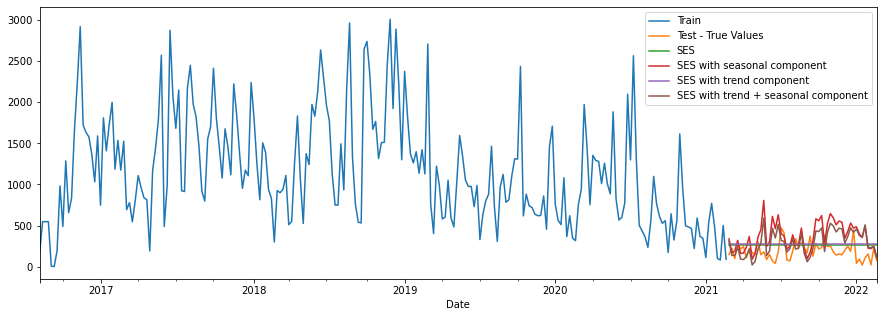

In [50]:
# Add columns
test['SES'] = fitted_model_1_fcast
test['SES with seasonal component'] = fitted_model_2_fcast
test['SES with trend component'] = fitted_model_3_fcast
test['SES with trend + seasonal component'] = fitted_model_4_fcast

train['Count'].plot(legend = True, label='Train', figsize=(15,5));
test['Count'].plot(legend = True, label='Test - True Values', figsize=(15,5));
test['SES'].plot(legend = True, figsize=(15,5));
test['SES with seasonal component'].plot(legend = True, figsize=(15,5));
test['SES with trend component'].plot(legend = True, figsize=(15,5));
test['SES with trend + seasonal component'].plot(legend = True, figsize=(15,5));

*Zoom-in to the test set only:*

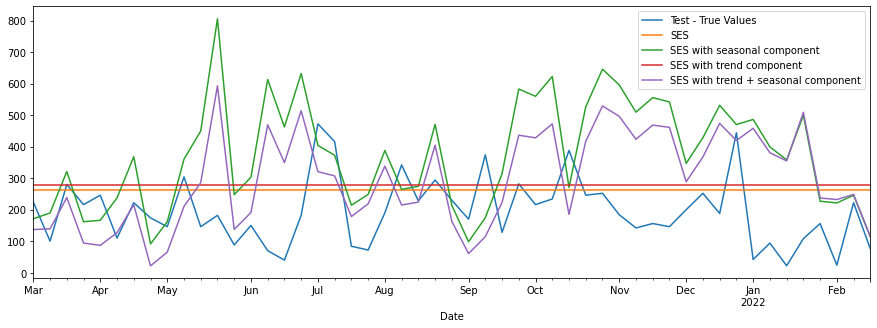

In [51]:
test['Count'].iloc[1:].plot(legend = True, label='Test - True Values', figsize=(15,5));
#test['Train mean'].iloc[1:].plot(legend = True, figsize=(15,5));
test['SES'].iloc[1:].plot(legend = True, figsize=(15,5));
test['SES with seasonal component'].iloc[1:].plot(legend = True, figsize=(15,5));
test['SES with trend component'].iloc[1:].plot(legend = True, figsize=(15,5));
test['SES with trend + seasonal component'].iloc[1:].plot(legend = True, figsize=(15,5));

*Evaluate:*

In [52]:
# True vs SES
result_1 = eval_models(test['Count'], test['SES'], "SES")
all_results = result_0.append(result_1)

# True vs SES + Seasonal
result_2 = eval_models(test['Count'], test['SES with seasonal component'], 
                       "SES with seasonal component")
all_results = all_results.append(result_2)

# True vs SES + Trend
result_3 = eval_models(test['Count'], test['SES with trend component'], 
                       "SES with trend component")
all_results = all_results.append(result_3)

# True vs SES + Trend + Seasonal
result_4 = eval_models(test['Count'], test['SES with trend + seasonal component'], 
                       "SES with trend + seasonal component")
all_results = all_results.append(result_4)

In [53]:
print(all_results.to_markdown())

|    | Model                               |     MAE |    RMSE |
|---:|:------------------------------------|--------:|--------:|
|  0 | Baseline - train mean               | 966.743 | 972.358 |
|  0 | SES                                 | 106.043 | 125.102 |
|  0 | SES with seasonal component         | 209.201 | 260.403 |
|  0 | SES with trend component            | 115.664 | 134.36  |
|  0 | SES with trend + seasonal component | 170.096 | 206.173 |


All Exponential Smoothing techniques performed much better than a baseline approach. The simplest model among SES models with just one parameter alpha performed the best.

##### 2. ARIMA

Let's check one of the most popular model for time series forecasting - the ARIMA method. It will test parameters using the auto_arima function based on AIC and we will build a model later.

In [54]:
from pmdarima import auto_arima

# AutoARIMA
fitted_model_5 = auto_arima(train['Count'], 
                            start_p=0, 
                            start_q=0, 
                            seasonal=True, 
                            trace=True, 
                            m=range_pred)
# m = a number of periods per each season (52 weeks per year) 
# fitted_model_5.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=3721.122, Time=2.76 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=3717.969, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=3704.717, Time=1.28 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=3683.397, Time=7.10 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=3715.971, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=3682.191, Time=0.21 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=3683.370, Time=4.79 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=3685.365, Time=12.08 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=3661.715, Time=0.31 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=3662.910, Time=8.56 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : AIC=3662.958, Time=9.74 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AIC=3664.901, Time=17.98 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=3703.394, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[52] intercept   : AIC=3663.438, Time=0.37 sec
 ARIMA(1,1,2)(0,0

In [55]:
# Model Prediction
fitted_model_5_fcast = fitted_model_5.predict(n_periods=len(test))

test['ARIMA'] = fitted_model_5_fcast

*Plot Results:*

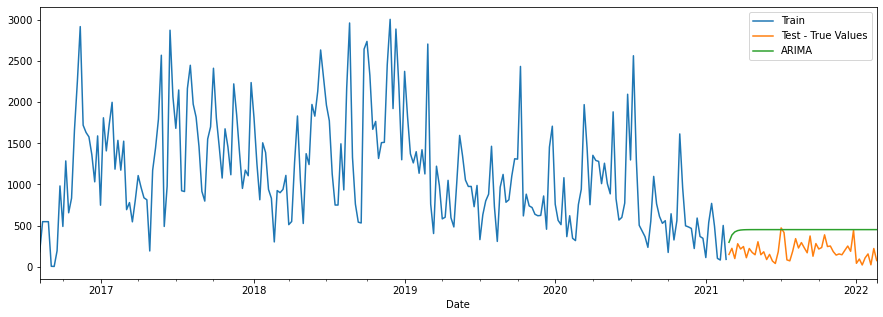

In [56]:
train['Count'].plot(legend = True, label='Train', figsize=(15,5));
test['Count'].plot(legend = True, label='Test - True Values', figsize=(15,5));
test['ARIMA'].plot(legend = True, figsize=(15,5));

*Evaluate:*

In [57]:
result_5 = eval_models(test['Count'], test['ARIMA'], "ARIMA")
all_results = all_results.append(result_5)
#all_results
print(all_results.to_markdown())

|    | Model                               |     MAE |    RMSE |
|---:|:------------------------------------|--------:|--------:|
|  0 | Baseline - train mean               | 966.743 | 972.358 |
|  0 | SES                                 | 106.043 | 125.102 |
|  0 | SES with seasonal component         | 209.201 | 260.403 |
|  0 | SES with trend component            | 115.664 | 134.36  |
|  0 | SES with trend + seasonal component | 170.096 | 206.173 |
|  0 | ARIMA                               | 252.765 | 273.249 |


Surprisingly, ARIMA performed very poorly compared to the other models (very high RMSE). One reason could be that no Seasonal ARIMA was chosen, but just ARIMA, despite we know there is a seasonality in our data. Weekly data could be challenging for modeling because the seasonal period (the number of weeks in a year) can change depending on the year and this had to be fixed in the auto_arima function as a parameter `m`.

##### 3. Facebook Prophet Model

Let's test Facebook library `Prophet` to forecast. It needs data to be converted into a specific format before modeling.

In [58]:
from fbprophet import Prophet

#Train
train_propeth = train.reset_index(level=0)
train_propeth.columns = ['ds' , 'y']

#Test
test_propeth = test[['Count']]
test_propeth = test_propeth.reset_index(level=0)
test_propeth.columns = ['ds' , 'y']

# Assign the datatime
train_propeth['ds'] = pd.to_datetime(train_propeth['ds'])
test_propeth['ds'] = pd.to_datetime(test_propeth['ds'])

In [59]:
#train_propeth.head()
print(train_propeth.head().to_markdown())

|    | ds                  |   y |
|---:|:--------------------|----:|
|  0 | 2016-08-07 00:00:00 | 182 |
|  1 | 2016-08-14 00:00:00 | 548 |
|  2 | 2016-08-21 00:00:00 | 548 |
|  3 | 2016-08-28 00:00:00 | 548 |
|  4 | 2016-09-04 00:00:00 |   6 |


In [60]:
#test_propeth.head()
print(test_propeth.head().to_markdown())

|    | ds                  |   y |
|---:|:--------------------|----:|
|  0 | 2021-02-28 00:00:00 | 150 |
|  1 | 2021-03-07 00:00:00 | 224 |
|  2 | 2021-03-14 00:00:00 | 100 |
|  3 | 2021-03-21 00:00:00 | 280 |
|  4 | 2021-03-28 00:00:00 | 216 |


*Build the model:*

In [61]:
# Build a model
m = Prophet(seasonality_mode= 'multiplicative')

# Fit to train data
m.fit(train_propeth)

# Assign periods to predict and freq
future = m.make_future_dataframe(periods = range_pred, freq='W') 
# number of periods, same length as test set (so we can easy evaluate the model)

# Forecast
forecast = m.predict(future)

#forecast.head()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


*Additional Capabilities of Prophet:*

Prophet has multiple built-in functions to investigate the time series. Let's check out two of them - the `Components Plot` and `Changepoints Plot`.

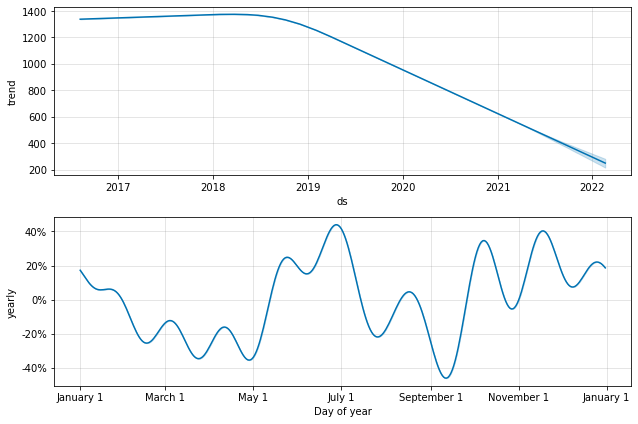

In [62]:
# Components Plot
m.plot_components(forecast);

`Changepoint Plot` - Show how the trend changed, the red line indicating when there were significant trend changes.

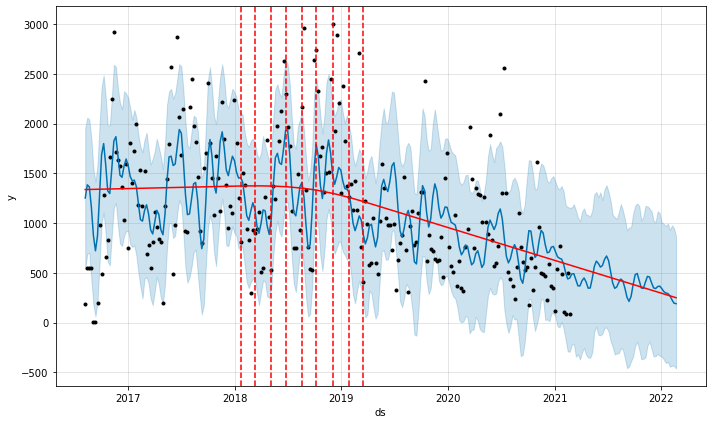

In [63]:
# Changepoint Plot
from fbprophet.plot import add_changepoints_to_plot

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

*Plot Results - Built-in Prophet capabilities:*

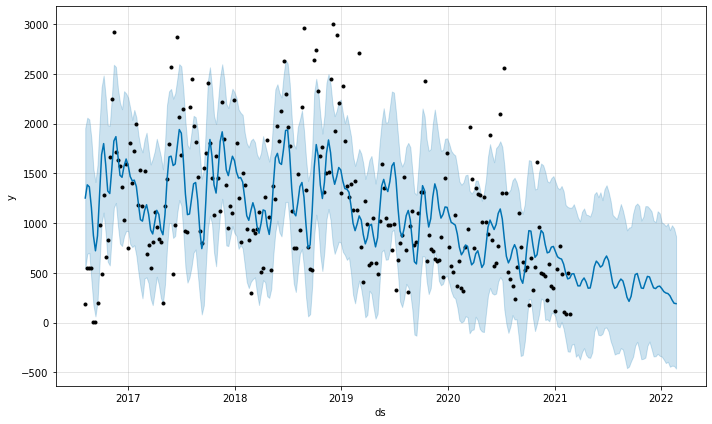

In [64]:
# Build in Prophet plotting capabilities
m.plot(forecast);

In [65]:
# Grab the first datetime in test set
beg_test_set = test.index[0].strftime('%Y-%m-%d')

# Grab only yhat for test set range from Prophet
forecast_to_eval = forecast[forecast['ds'] >= beg_test_set][['ds','yhat']]
forecast_to_eval.columns = ['Date', 'Prophet']

# Attach results to the test dataframe
test = pd.merge(test, forecast_to_eval, left_index=True, right_on='Date')
# Set Date as index
test['Date'] = pd.to_datetime(test['Date'])
test.set_index('Date',inplace=True)

#test.head()

*Plot Results - Zoom in to the test set only:*

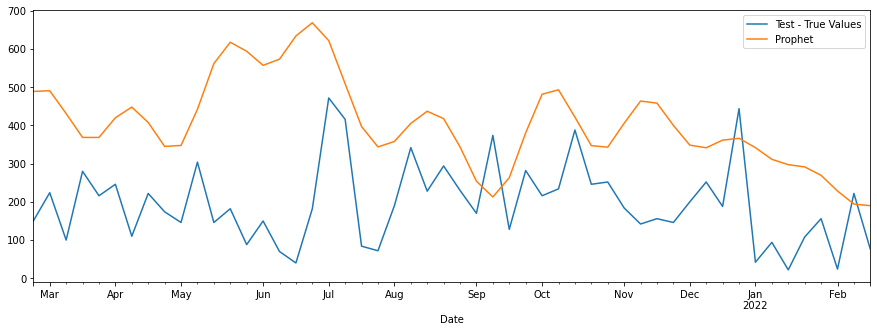

In [66]:
test['Count'].plot(legend = True, label='Test - True Values', figsize=(15,5));
test['Prophet'].plot(legend = True, figsize=(15,5));

*Evaluate:*

In [67]:
result_6 = eval_models(test['Count'], test['Prophet'], "Prophet")
all_results = all_results.append(result_6)

print(all_results.to_markdown())

|    | Model                               |     MAE |    RMSE |
|---:|:------------------------------------|--------:|--------:|
|  0 | Baseline - train mean               | 966.743 | 972.358 |
|  0 | SES                                 | 106.043 | 125.102 |
|  0 | SES with seasonal component         | 209.201 | 260.403 |
|  0 | SES with trend component            | 115.664 | 134.36  |
|  0 | SES with trend + seasonal component | 170.096 | 206.173 |
|  0 | ARIMA                               | 252.765 | 273.249 |
|  0 | Prophet                             | 221.184 | 257.256 |


##### 4. ARIMAX - with exogenous variable

The last method we wanna test out is the ARIMA model again, but with an exogenous variable - holiday. The assumption is that number of messages sent during a week could be affected by the number of holidays during that week.

*Prepare the data:*

In [68]:
# Holiday .csv contains polish holidays for years 2001 to 2025
holiday_df_all = pd.read_csv('holiday.csv')
holiday_df_all.columns = ['Date', 'Holiday_Name']
holiday_df_all['Date'] = pd.to_datetime(holiday_df_all['Date'])
holiday_df_all.set_index('Date',inplace=True)

# Filter holidays for dates in our dataset
holiday_df_all = holiday_df_all.sort_values('Date')
holiday_df = holiday_df_all.loc['2016-08-04':'2022-02-15']

print(holiday_df.head().to_markdown())

| Date                | Holiday_Name                           |
|:--------------------|:---------------------------------------|
| 2016-08-15 00:00:00 | Wniebowziecie Najswietszej Marii Panny |
| 2016-11-01 00:00:00 | Uroczystosc Wszystkich Swietych        |
| 2016-11-11 00:00:00 | Narodowe Swieto Niepodleglosci         |
| 2016-12-25 00:00:00 | pierwszy dzien Bozego Narodzenia       |
| 2016-12-26 00:00:00 | drugi dzien Bozego Narodzenia          |


Add the `holiday` column into the our dataset.

In [69]:
# Need to come back to the daily dataframe and convert current to dates with Y/M/D only
df_sarimax = df.reset_index(level=0)
df_sarimax['Date'] = df_sarimax['Date'].dt.strftime('%m/%d/%Y')
df_sarimax['Date'] = pd.to_datetime(df_sarimax['Date'])
df_sarimax.set_index('Date',inplace=True)

# Resample daily
df_sarimax_res_d = df_sarimax['Name'].resample(rule='D').count().to_frame('Count')

# To resampled daily data attach holiday column 
df_sarimax_res_d = df_sarimax_res_d.join(holiday_df)

# Fill Nan with zeros
df_sarimax_res_d['Holiday_Name_fill'] = np.where(df_sarimax_res_d['Holiday_Name'].isnull(), 0, 1)

print(df_sarimax_res_d.head().to_markdown())

| Date                |   Count |   Holiday_Name |   Holiday_Name_fill |
|:--------------------|--------:|---------------:|--------------------:|
| 2016-08-04 00:00:00 |      36 |            nan |                   0 |
| 2016-08-05 00:00:00 |     146 |            nan |                   0 |
| 2016-08-06 00:00:00 |       0 |            nan |                   0 |
| 2016-08-07 00:00:00 |       0 |            nan |                   0 |
| 2016-08-08 00:00:00 |       0 |            nan |                   0 |


Plot the daily data and overlap it with holidays (a grey vertical line indicates if that day is a holiday). A couple of blue peaks on the plot overlap with holidays.

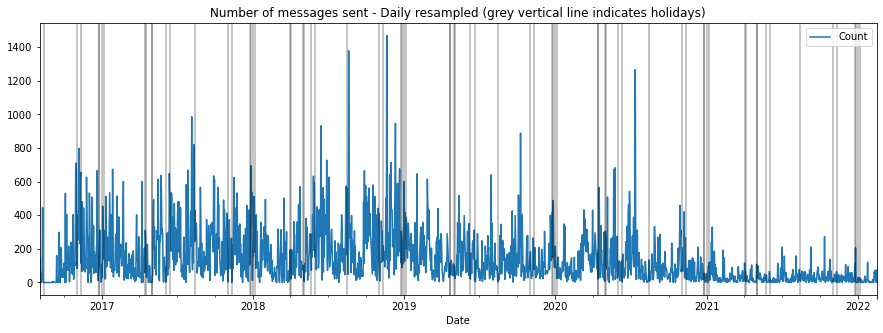

In [70]:
ax = df_sarimax_res_d['Count'].plot(
    legend=True,figsize=(15,5), 
    title = 'Number of messages sent - Daily resampled (grey vertical line indicates holidays)')

# Overlap if holiday 
for x in df_sarimax_res_d.query('Holiday_Name_fill>=1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

Now, prepare the data for prediction (resampled weekly). We need to count a number of holidays for each week and attach this info to the train and test dataset.

In [71]:
# Resample Weekly
df_sarimax_final = df_sarimax_res_d['Count'].resample(rule='W').sum().to_frame('Count')

# Sum number of holidays per week
df_sarimax_final['Count_Holiday'] = df_sarimax_res_d['Holiday_Name_fill'].resample(
    rule='W').sum().to_frame('Count_Holiday')

print(df_sarimax_final.head().to_markdown())

| Date                |   Count |   Count_Holiday |
|:--------------------|--------:|----------------:|
| 2016-08-07 00:00:00 |     182 |               0 |
| 2016-08-14 00:00:00 |     548 |               0 |
| 2016-08-21 00:00:00 |       0 |               1 |
| 2016-08-28 00:00:00 |       0 |               0 |
| 2016-09-04 00:00:00 |       6 |               0 |


Plot the weekly data and overlap it with holidays (grey vertical line indicates if that day is a holiday).

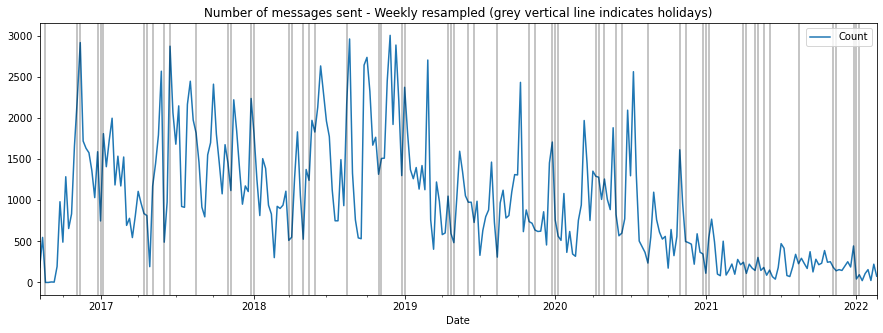

In [72]:
ax = df_sarimax_final['Count'].plot(
    legend=True,figsize=(15,5),
    title = 'Number of messages sent - Weekly resampled (grey vertical line indicates holidays)')

for x in df_sarimax_final.query('Count_Holiday>=1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

*Train/ Test Split with the same range as before:*

In [73]:
# Train/Test split
train_ex = df_sarimax_final[:-range_pred]
test_ex = df_sarimax_final[-range_pred:]
print('Train Set Dates')
print(train_ex.index.min())
print(train_ex.index.max())

print('Test Set Dates')
print(test_ex.index.min())
print(test_ex.index.max())

Train Set Dates
2016-08-07 00:00:00
2021-02-21 00:00:00
Test Set Dates
2021-02-28 00:00:00
2022-02-20 00:00:00


*Build ARIMAX model:*

In [74]:
# AutoARIMA with the same input values as for AutoARIMA
fitted_model_5_ex = auto_arima(train_ex['Count'], 
                               exogenous = train_ex[['Count_Holiday']], 
                               seasonal = True, 
                               trace=False, 
                               m=range_pred) 

In [75]:
# Get Summary/ Parameters of ARIMA
# fitted_model_5_ex.summary()
fitted_model_5_ex

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 52),
      suppress_warnings=True, with_intercept=False)

*ARIMAX Predictions:*

In [76]:
fitted_model_5_ex_fcast = fitted_model_5_ex.predict(
    n_periods=len(test_ex), exogenous = test_ex[['Count_Holiday']])

test_ex['ARIMA Exogenous'] = fitted_model_5_ex_fcast

In [77]:
# Attach holiday column
test['Count_Holiday'] = df_sarimax_final['Count_Holiday']
test['ARIMA Exogenous'] = fitted_model_5_ex_fcast

*Plot Results:*

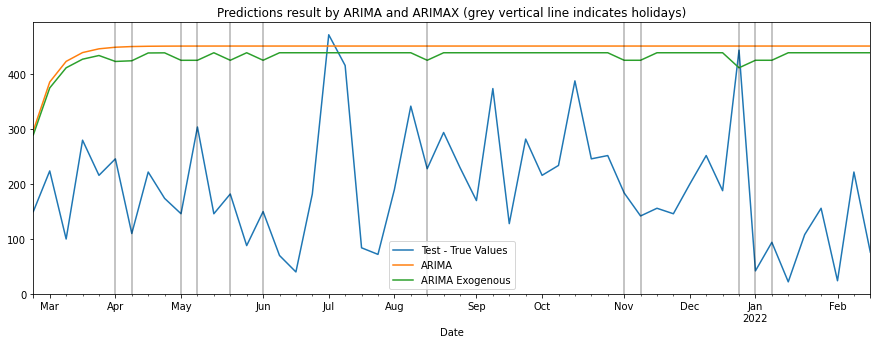

In [78]:
ax = test['Count'].plot(legend = True, 
                        label='Test - True Values', figsize=(15,5),
                       title = 'Predictions result by ARIMA and ARIMAX (grey vertical line indicates holidays)');
ax = test['ARIMA'].plot(legend = True, figsize=(15,5));
ax = test['ARIMA Exogenous'].plot(legend = True, figsize=(15,5));

for x in test.query('Count_Holiday>=1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

Interestingly the `holiday` variable has slightly decreased the predictions during the holiday periods.

*Evaluate:*

In [79]:
result_7 = eval_models(test['Count'], test['ARIMA Exogenous'], "ARIMA Exogenous")
all_results = all_results.append(result_7)
all_results_plot = all_results.set_index('Model')

print(all_results_plot.to_markdown())

| Model                               |     MAE |    RMSE |
|:------------------------------------|--------:|--------:|
| Baseline - train mean               | 966.743 | 972.358 |
| SES                                 | 106.043 | 125.102 |
| SES with seasonal component         | 209.201 | 260.403 |
| SES with trend component            | 115.664 | 134.36  |
| SES with trend + seasonal component | 170.096 | 206.173 |
| ARIMA                               | 252.765 | 273.249 |
| Prophet                             | 221.184 | 257.256 |
| ARIMA Exogenous                     | 238.963 | 259.187 |


ARIMA with an Exogenous variable has performed slightly better compared to ARIMA, but RMSE is still relatively high compared to other methods.

# *V. Conclusion*

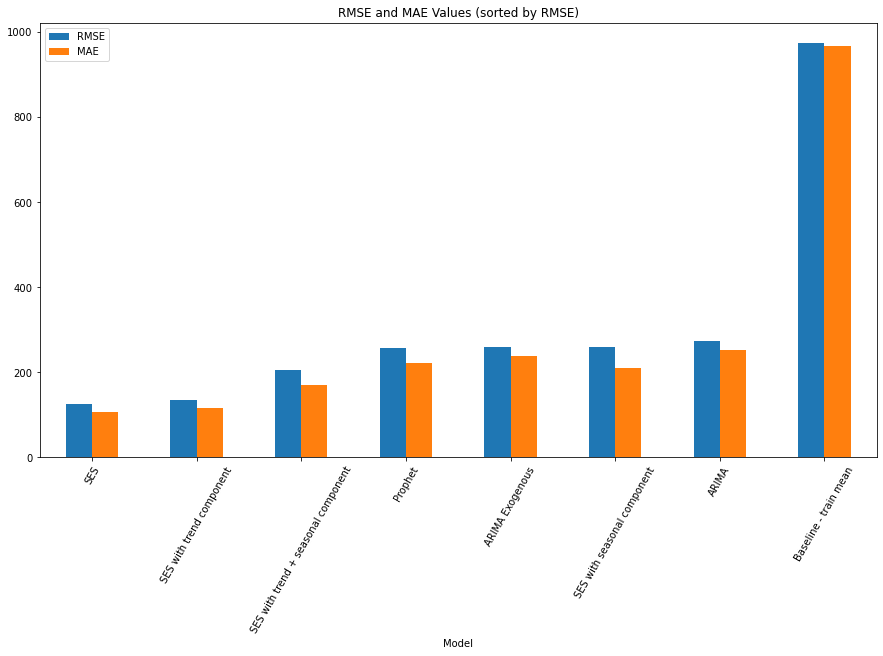

In [80]:
all_results_plot[['RMSE', 'MAE']].sort_values(ascending=True, by='RMSE').plot(
    kind = 'bar', rot=60, title='RMSE and MAE Values (sorted by RMSE)', figsize=(15,8));

All models performed significantly better than a baseline. The best results (lowest RMSE) achieved the simplest Simple Exponential Smoothing (SES) model, just with one smoothing parameter (alpha).

# *VI. Forecast the Unknown Future*

In the last part, we will make forecasts into the unknown future above the data in the dataset. Thus, we will retrain the models using the whole data (train+test) and make predictions for another 52 weeks (which is from week of 2022-02-27, until the week of 2023-02-19). We won't be evaluating models, since we don't know the future but will do that in a couple of weeks/ months.

### Define the data

We use the same dataframe `df_pred` which is already resampled weekly data, but this time we will build on the whole dataset.

In [81]:
df_pred_forecast = df_pred
print('From week: ', df_pred_forecast.index.min())
print('To week: ', df_pred_forecast.index.max())

From week:  2016-08-07 00:00:00
To week:  2022-02-20 00:00:00


In [82]:
# We again predict 52 weeks into the future
range_pred

52

In [83]:
# Replace 0 by the previous' row value
df_pred_forecast['Count'] = df_pred_forecast['Count'].replace(
    to_replace=0, method='ffill')

df_pred_forecast[df_pred_forecast['Count'] == 0].count()

Count    0
dtype: int64

### Rebuild Models

##### 1. Simple Exponential Smoothing - Single, Double and Triple

In [84]:
#1 SES
fitted_model_1_future = ExponentialSmoothing(
    df_pred_forecast['Count']).fit()
fitted_model_1_fcast_future = fitted_model_1_future.forecast(
    range_pred).rename('SES (FUTURE)')

#2 DES (seasonal) 
fitted_model_2_future = ExponentialSmoothing(
    df_pred_forecast['Count'], seasonal='add').fit(use_boxcox=True)
fitted_model_2_fcast_future = fitted_model_2_future.forecast(
    range_pred).rename('SES with seasonal component (FUTURE)')

#3 DES (trend with 'damped' True)
fitted_model_3_future = ExponentialSmoothing(
    df_pred_forecast['Count'], trend='add', damped=True)
fitted_model_3_fcast_future = fitted_model_3_future.fit().forecast(
    range_pred).rename('SES with trend component (FUTURE)')

#4 TES (trend + seasonal)
fitted_model_4_future = ExponentialSmoothing(
    df_pred_forecast['Count'], trend='add', seasonal='add')
fitted_model_4_fcast_future = fitted_model_4_future.fit(
    use_boxcox=True).forecast(range_pred).rename(
    'SES with trend + seasonal component (FUTURE)')

##### 2. ARIMA

In [85]:
# AutoARIMA
fitted_model_5_future = auto_arima(df_pred_forecast['Count'], 
                            start_p=0, 
                            start_q=0, 
                            seasonal=True, 
                            trace=False, 
                            m=range_pred)

#fitted_model_5_future.summary()
fitted_model_5_future

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 52),
      suppress_warnings=True, with_intercept=False)

In [86]:
# Model Prediction for the next year
fitted_model_5_fcast_future = fitted_model_5_future.predict(n_periods=range_pred)

##### 3. Facebook Prophet Model

In the dataset, the very last data points approach values closely to zero and Prophet forecasts negative values for the future. We will use a Box-Cox transformation for prediction and inverse the transformation for plotting.

In [87]:
# Combine datasets
train_propeth['ds'] = pd.to_datetime(train_propeth['ds'])
test_propeth['ds'] = pd.to_datetime(test_propeth['ds'])

# Append
Prophet_full = train_propeth.append(test_propeth)

# Apply Box-Cox Transform
from scipy.stats import boxcox
Prophet_full['y'], lam = boxcox(Prophet_full['y'])

In [88]:
# Build a model
m_future_model_6 = Prophet(seasonality_mode= 'multiplicative')

# Fit to train data
m_future_model_6.fit(Prophet_full)

# Assign periods to predict and freq
future_future_fst_6= m_future_model_6.make_future_dataframe(
    periods = range_pred, freq='W') 

# Forecast
future_future_fst_6 = m_future_model_6.predict(future_future_fst_6)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [89]:
# Apply inverse Box-Cox transform to specific forecast columns
from scipy.special import inv_boxcox
future_future_fst_6[['yhat','yhat_upper','yhat_lower']] = future_future_fst_6[[
    'yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))

# Define the last timestamp in the dataset
last_date = df_pred_forecast.index.max().strftime('%Y-%m-%d')

# Grab only yhat for the future dates
forecast_future_to_store_m_6 = future_future_fst_6[
    future_future_fst_6['ds'] >= last_date][['ds','yhat']]
forecast_future_to_store_m_6 = forecast_future_to_store_m_6.iloc[1:]

# Rename columns
forecast_future_to_store_m_6.columns = ['Date', 'Prophet (FUTURE)']

##### 4. ARIMAX - with exogenous variable

*Build the model:*

In [90]:
# Combine train and test data used in previous ARIMAX model
df_pred_forecast_ex = train_ex[['Count', 'Count_Holiday']].append(
    test_ex[['Count', 'Count_Holiday']])

# AutoARIMA with the same input values as for AutoARIMA
fitted_model_7_ex = auto_arima(df_pred_forecast_ex['Count'], 
                               exogenous = df_pred_forecast_ex[['Count_Holiday']], 
                               seasonal = True, 
                               trace=False, 
                               m=range_pred) 
#fitted_model_7_ex.summary()
fitted_model_7_ex

ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(0, 0, 0, 52),
      suppress_warnings=True, with_intercept=False)

*Define the data for predictions:* <br/> 
Since we use an exogenous variable we need to attach a column with holidays for the future dates to support predictions.

In [91]:
# Define date ranges for prediction
dates_to_predict = pd.date_range(start=df.index.max().strftime('%Y-%m-%d'), 
                                 periods=365, freq='D')
# Convert to df
dates_to_predict = pd.DataFrame(dates_to_predict, columns=['Date'])
dates_to_predict = dates_to_predict.set_index('Date')

# Attach a holiday column 
dates_to_predict = dates_to_predict.join(holiday_df_all)

# Fill Nan with zeros
dates_to_predict['Holiday_Name_fill'] = np.where(
    dates_to_predict['Holiday_Name'].isnull(), 0, 1)

# Resample weekly
dates_to_predict = dates_to_predict['Holiday_Name_fill'].resample(
    rule='W').sum().to_frame('Count_Holiday')

# Adjust the week periods to match other models' ranges
dates_to_predict = dates_to_predict.iloc[1:]

*Predictions:* 

In [92]:
fitted_model_7_ex_future = fitted_model_7_ex.predict(
    n_periods=len(dates_to_predict), 
    exogenous = dates_to_predict[['Count_Holiday']])

### Combine Forecasts and Plot the future

In [93]:
# df for holding the future
forecast_future = pd.DataFrame()

# 1. Simple Exponential Smoothing 
forecast_future['SES (FUTURE)'] = fitted_model_1_fcast_future
forecast_future['SES with seasonal component (FUTURE)'] = fitted_model_2_fcast_future
forecast_future['SES with trend component (FUTURE)'] = fitted_model_3_fcast_future
forecast_future['SES with trend + seasonal component (FUTURE)'] = fitted_model_4_fcast_future

# 2. ARIMA
forecast_future['ARIMA (FUTURE)'] = fitted_model_5_fcast_future

# 3. Prophet
forecast_future = pd.merge(forecast_future, forecast_future_to_store_m_6, 
                           left_index=True, right_on='Date')
forecast_future = forecast_future.set_index('Date')

# 4. ARIMAX
forecast_future['ARIMA Exogenous (FUTURE)'] = fitted_model_7_ex_future

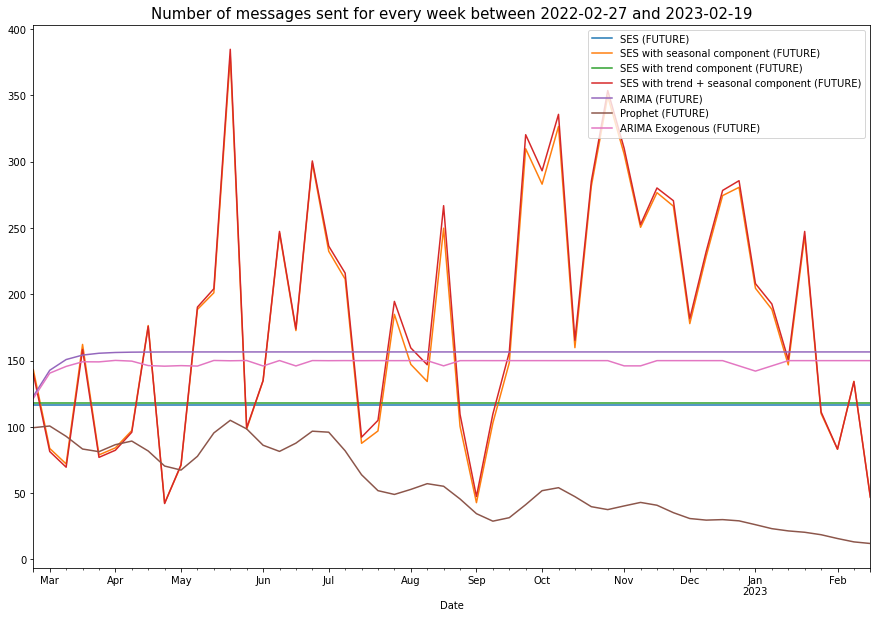

In [94]:
ax = forecast_future.plot(figsize=(15,10));
ax.set_title("Number of messages sent for every week between 2022-02-27 and 2023-02-19",fontsize=15);


In a couple of weeks/ months, we will come back to those forecasted values and see which method was the closest to truth.